### Causal Inference

Notes:
There are four steps:

1) **Define causal graph**

2) **Identify estimand (<- it automatically gives you expression & assumptions)**

3) **Use statistical/ML methods to get estimates**

4) **Refutation Test**

1.   Currently I compare two races at a time: use white as control, and black/hispanic/asian & pacific islander as treatment.

2.   I haven't fully understand the 'estimate estimand' part, there are many methods to choose from (causal inference method / Machine Learning method), need to choose the most suitable method for this problem. I also need to read related documentation to underswtand how the estimates are calculated.

3.   It is worth noting that when unobserved confounding factors are present (variables that influence both the treatment and the outcome), the results obtained may not be valid.

4.   It is worth noting that if the causal graph DEFINED is wrong, the results are not valid.

5. Refutation tests help us check some of the assumptions made when we define the causal graph.  

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
import os 
drive.mount('/gdrive/')

Mounted at /gdrive/


### Data Preprocessing

In [ ]:
#!pip install pyarrow
! pip install PyAstronomy

     |████████████████████████████████| 727 kB 7.5 MB/s 
     |████████████████████████████████| 85 kB 3.1 MB/s 
  Created wheel for PyAstronomy: filename=PyAstronomy-0.17.0-py3-none-any.whl size=522050 sha256=462ce30d9dd251ff47c376bb9f37accde71cb34e982568cbf7b65307dcbdaf5a
  Stored in directory: /root/.cache/pip/wheels/10/f4/cc/fe117c538c81443a6ba0e852ee8d69866a08e5163d2050aae5
  Created wheel for quantities: filename=quantities-0.12.5-py3-none-any.whl size=80135 sha256=87a7dcfed79c91cbc06cd823ebecfd5db4df96d48a938dd0231ef402abc4f2e1
  Stored in directory: /root/.cache/pip/wheels/67/e7/32/0bb6d5bd0f619e583b6f1f4c710b535df898a1083e1e5d066c
Successfully built PyAstronomy quantities


In [ ]:
import pandas as pd
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
#from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
#from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
#import statsmodels.api as sm
#from sklearn.metrics import classification_report, roc_curve, auc

In [ ]:
def remove_empty_rows(df, colName):
	df = df[df[colName] != 'unknown']
	df = df[df[colName].notna()]
	return(df)
 
def exclusive(vio_lst):
  for vio in vio_lst:
    # if there is any violation other than speeding, return 0
    if 'speed' not in vio:
      return 0
  # if all of the violations (for this record) include speeding, return 1
  return 1
 
def preprocess(df, keep_col, rm_na_col, violation_type = None):

  start = time.time()
  # drop unrelated columns
  col_drop = [col for col in df.columns if col not in keep_col]
  df.drop(col_drop, axis = 1, inplace = True)

  # remove rows with missing values in rm_na_col
  for col in rm_na_col:
    df = remove_empty_rows(df, col)

  # convert violation to lower cases
  df['violation'] = [s.lower() for s in df['violation']]

  # if we only want to include certain violation type:
  if violation_type == 'speed':
    df = df.loc[df['violation'].str.contains('speed', regex=False),:]

  # if we only want to include cases with no violations other than speeding
  if violation_type == 'speed_exclusive':
    df = df.loc[df['violation'].str.contains('speed', regex = False),:]
    df['violation'] = df['violation'].map(lambda x: x.replace('(#)',''))
    df['violation'] = df['violation'].map(lambda x: x.strip())
    # get a list of violations for each record, and apply self-defined func exclusive
    df['all_violation'] = df['violation'].str.split('|')
    df['speeding_only'] = df['all_violation'].map(lambda x: exclusive(x))
    # filter out rows with violations other than speeding
    df = df.loc[df['speeding_only'] == 1,:]
    df.drop(['speeding_only','all_violation'], axis = 1, inplace = True)

  # after selecting based on violation, drop the column
  df.drop('violation', 1, inplace=True)

  # adding time of year info
  df['year'] = pd.to_datetime(df['date']).dt.year
  df['yearfrac'] = [pyasl.decimalYear(d) for d in pd.to_datetime(df['date'])]
  df['yearfrac'] = df['yearfrac'] - df['year']
  df['minute'] = df['time'].map(lambda x: x.minute)
  df['hour'] = df['time'].map(lambda x: x.hour)
  df['time'] = df['hour'] + df['minute'] / 60
  scaler = MinMaxScaler()
  scaler.fit(np.array(df['time']).reshape(-1,1))
  df['time'] = scaler.transform(np.array(df['time']).reshape(-1,1))
  df.drop(['hour', 'minute', 'date', 'year'], 1, inplace=True)
        
  # County names are converted to county type - metropolitan, micropolitan or non-core
  # For definitions, see US OMB website

  # read in county info csv
  county_df = pd.read_csv('/gdrive/MyDrive/traffic_stop/2014-2018.csv')
  county_df = county_df[county_df['State']=='Texas']
  county_df = county_df.filter(items=['Metropolitan Status', 'County Name'])

  # transform column
  df['county_name'] = [name[:-7] for name in df['county_name']]
  df = df.join(county_df.set_index('County Name'), on='county_name')
  df.drop('county_name', 1, inplace=True)
  df.rename(columns={'Metropolitan Status':'county_type'}, inplace=True)
  print(df['county_type'].isnull().sum())
  # Convert citation issued and warning issued columns to integer
  df = df.astype({'citation_issued': 'int64'})

  # search and contraband related variables have three levels: None, True, False, if not True, use 0, else 1
  for col in ['contraband_found','contraband_drugs','contraband_weapons','search_conducted','search_vehicle']:
    df[col] = df[col].map({True: 1, False: 0, None: 0})

  # if race is 'other'/'unknown', make them one level other/unknown
  # df['subject_race'] = df['subject_race'].replace({'other':'other/unknown','unknown':'other/unknown'})
  # update: if race is other/unknown, we delete the rows!
  df = df.loc[(df['subject_race'] != 'unknown') & (df['subject_race'] != 'other'),:]
  #print(df['subject_race'].value_counts())
  # get dummies for race and sex
  #df = pd.get_dummies(df)
 
  # Base level: White, Male, Non_core (county type)
  #df.drop(['subject_race_white', 'subject_sex_male', 'county_type_Non core','subject_race_other','subject_race_unknown'], axis = 1, inplace = True)
  print(df.columns)
  print('preprocessing time: %d'%(time.time()-start))
  return df 

In [ ]:
!pip install dowhy

     |████████████████████████████████| 123 kB 8.2 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [ ]:
!sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
graphviz is already the newest version (2.40.1-2).
python3-dev is already the newest version (3.6.7-1~18.04).
python3-dev set to manually installed.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24

In [ ]:
!sudo pip install pygraphviz

     |████████████████████████████████| 118 kB 7.4 MB/s 
  Created wheel for pygraphviz: filename=pygraphviz-1.7-cp37-cp37m-linux_x86_64.whl size=165728 sha256=e3c2a4463b69d728e73c681eb4159783db8a4c28f74ab808d91abf4137e20398
  Stored in directory: /root/.cache/pip/wheels/8c/bc/0c/ac35392b72556e75107ff610cb31b313e8471918a6d280e34c
Successfully built pygraphviz


In [ ]:
import dowhy
import pygraphviz

### Yearly Analysis

#### White VS [Black,hispanic,asian | pacific islander]

In [ ]:
causal_graph = """digraph {
subject_sex;
time[label="Fraction of Day"];
yearfrac[label="Fraction of Year"]
subject_race;
citation_issued;
county_type;	
contraband_found;
contraband_drugs;
contraband_weapons;
search_conducted;
subject_race -> citation_issued;
subject_race -> search_conducted;
search_conducted -> citation_issued;
search_conducted -> contraband_found;
search_conducted -> contraband_drugs;
search_conducted -> contraband_weapons;
time -> citation_issued;
county_type -> citation_issued;
subject_sex -> citation_issued;
contraband_found -> citation_issued;
contraband_drugs -> citation_issued;
contraband_weapons -> citation_issued;
yearfrac -> citation_issued;
U[label="Unobserved Confounders"]; 
U->subject_race; U->citation_issued;
}"""


In [ ]:
df_b['contraband_found'] = df_b['contraband_found'].astype('float')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


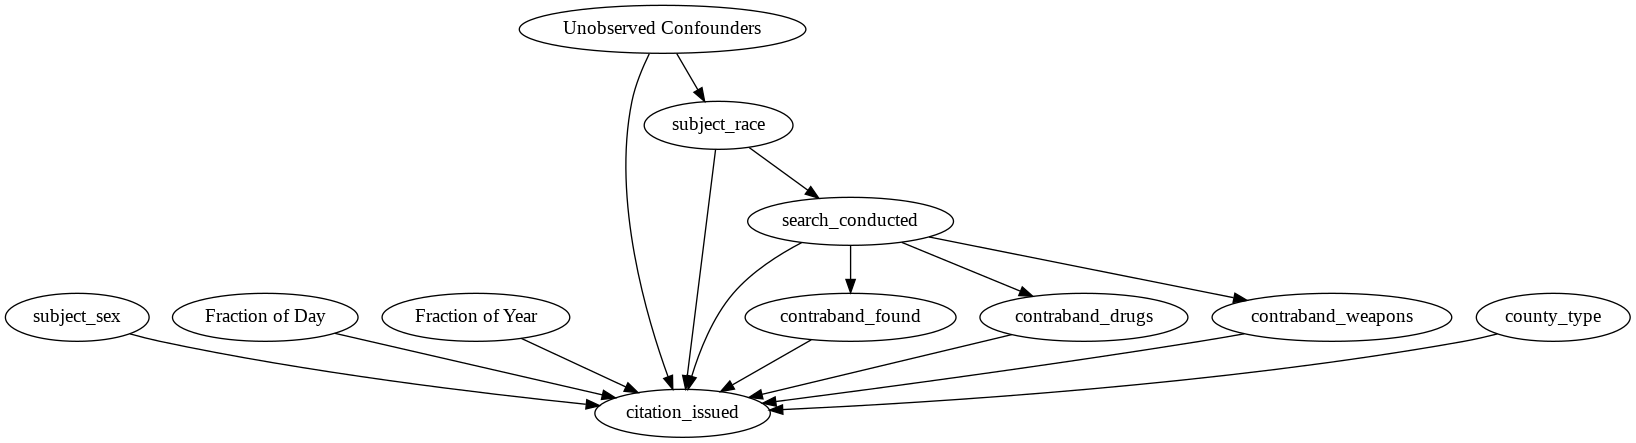

In [ ]:
model = dowhy.CausalModel(data=df_b,
                     graph=causal_graph.replace("\n", " "),
                     treatment="subject_race",
                     outcome="citation_issued")

model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [ ]:
black = []
hispanic = []
asianpacific = []
temp_estimate = []

In [ ]:
keep_col = ['date', 
                'time', 
                'county_name', 
                'subject_race',
                'subject_sex',
                'violation', 
                'citation_issued',
                'contraband_found',
                'contraband_drugs',
                'contraband_weapons',
                'search_conducted',
                'search_vehicle',
                'daytime'
                ]
rm_na_col = ['county_name','violation','subject_race','subject_sex']

In [ ]:
import pandas as pd
path_name = '/gdrive/MyDrive/traffic_stop/year_data_daylight/' + 'traffic_2013' + '.parquet'
df = pd.read_parquet(path_name, engine = 'pyarrow')
df.head()

,raw_row_number,date,time,location,lat,lng,county_name,district,precinct,region,subject_race,subject_sex,officer_id_hash,type,violation,citation_issued,warning_issued,outcome,contraband_found,contraband_drugs,contraband_weapons,search_conducted,search_vehicle,search_basis,vehicle_color,vehicle_make,vehicle_model,vehicle_type,vehicle_year,raw_HA_RACE_SEX,raw_HA_SEARCH_PC_boolean,raw_HA_SEARCH_CONCENT_boolean,raw_HA_INCIDTO_ARREST_boolean,raw_HA_VEHICLE_INVENT_boolean,year,sunset,sunrise,time_str,daytime
0,17976341,2013-01-01,00:34:00,"route: 0035, milepost: 380",32.137798,-96.948814,Ellis County,A,None,1,black,male,e6fa26c36b,vehicular,No/Non-Compliant Head Lamps (#),False,True,warning,None,None,None,False,False,NaN,None,VANGUA,VAN,TT,2008.0,BM,False,False,False,False,2013,17:34:00,07:29:00,00:34:00,0
1,17976342,2013-01-01,00:34:00,"route: 0281, milepost: 262",33.083217,-98.066398,Jack County,A,None,5,white,male,54ed931287,vehicular,No/Improper License Plate Lamp,False,True,warning,None,None,None,False,False,NaN,None,DODG,NIT,SV,2008.0,WM,False,False,False,False,2013,17:36:00,07:36:00,00:34:00,0
2,17976344,2013-01-01,00:35:00,"route: 0006, milepost: 374",32.221733,-98.715530,Eastland County,C,None,5,hispanic,male,946554984c,vehicular,Drive On Improved Shoulder When Prohibited|Fai...,False,True,warning,None,None,None,False,False,NaN,WHI,CHEV,PK,PU,2004.0,WM,False,False,False,False,2013,17:41:00,07:36:00,00:35:00,0
3,17976345,2013-01-01,00:35:00,"route: 0020, milepost: 309",31.902099,-102.256332,Midland County,A,10,4,hispanic,male,d094efa6e7,vehicular,Minor Consume Alcohol Beverage - Misdemeanor|S...,True,False,citation,None,None,None,False,False,NaN,BLACK,FORD,FIS,PA,2011.0,HM,False,False,False,False,2013,17:56:00,07:50:00,00:35:00,0
4,17976346,2013-01-01,00:35:00,"route: 0020, milepost: 309",31.902099,-102.256332,Midland County,A,10,4,hispanic,female,d094efa6e7,vehicular,Minor Consume Alcohol Beverage - Misdemeanor,True,False,citation,None,None,None,False,False,NaN,BLACK,FORD,FIS,PA,2011.0,HF,False,False,False,False,2013,17:56:00,07:50:00,00:35:00,0


In [ ]:
years = []
for i in range(2006, 2018):
  years.append(i)

# causal graph is a parameter
races = ['black', 'hispanic', 'asian/pacific islander']
for race in races:
  temp_estimate = []
  for year in years:

    # read data files
    file_name = 'traffic_' + str(year)
    path_name = '/gdrive/MyDrive/traffic_stop/year_data_daylight/' + file_name + '.parquet'
    df = pd.read_parquet(path_name, engine = 'pyarrow')

    # preprocess data
    df = preprocess(df = df,keep_col = keep_col, rm_na_col = rm_na_col)

    # do causal estimates
    df_b = df.loc[df['subject_race'].isin(['white', race])]
    df_b['subject_race'] = df_b['subject_race'].map({'white':0, race:1})
    df_b['subject_sex'] = df_b['subject_sex'].map({'male':0, 'female':1})
    df_b['county_type'] = df_b['county_type'].map({'Non core':0, 'Micropolitan':1, 'Metropolitan':2})

    # delete rows with missing values in county_type
    df_b = df_b[df_b['county_type'].notna()]

    # 1) define model based on the graph
    model = dowhy.CausalModel(data=df_b,
                      graph=causal_graph.replace("\n", " "),
                      treatment="subject_race",
                      outcome="citation_issued")
    df_b['subject_race'] = df_b['subject_race'].map(lambda x: bool(x))
    df_b['contraband_found'] = df_b['contraband_found'].map(lambda x: bool(x))
    # 2) identify estimand
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    print('---------------------------------------------------')
    print(race, ' *****', year)
    print(identified_estimand)
    # estimate estimand
    # 3) The propensity score is a balancing score: conditional on the propensity score, the distribution of measured baseline  
    # covariates is similar between treated and untreated subjects.
    estimate = model.estimate_effect(identified_estimand, 
                                    method_name="backdoor.propensity_score_stratification")
    print(estimate)
    temp_estimate.append(estimate.value)
    # refutation test
    res_placebo=model.refute_estimate(identified_estimand, estimate,
          method_name="placebo_treatment_refuter", placebo_type="permute")
    print(res_placebo)
    print('---------------------------------------------------')
  if race == 'black':
    black = temp_estimate
  if race == 'hispanic':
    hispanic = temp_estimate
  if race == 'asian/pacific islander':
    asianpacific = temp_estimate

6281
Index(['time', 'subject_race', 'subject_sex', 'citation_issued',
       'contraband_found', 'contraband_drugs', 'contraband_weapons',
       'search_conducted', 'search_vehicle', 'daytime', 'yearfrac',
       'county_type'],
      dtype='object')
preprocessing time: 66
---------------------------------------------------
black  ***** 2006
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
───────────────(Expectation(citation_issued|county_type,time,yearfrac,subject_
d[subject_race]                                                               

     
sex))
     
Estimand assumption 1, Unconfoundedness: If U→{subject_race} and U→citation_issued then P(citation_issued|subject_race,county_type,time,yearfrac,subject_sex,U) = P(citation_issued|subject_race,county_type,time,yearfrac,subject_sex)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estima

In [ ]:
print('black: ', black)
print('hispanic: ', hispanic)
print('asian/pacific: ', asianpacific)
print('asian/pacific: ',temp_estimate)

black:  [0.03121936511152049, 0.03145944989479127, 0.049482928483087045, 0.057625147763473515, 0.06392286739764856, 0.07063378582341973, 0.07231532298573957, 0.09004331698085316, 0.09540466148970482, 0.10350184497814285, 0.10529821258349384, 0.11265868228187789]
hispanic:  [0.06696457620101424, 0.06909371398744672, 0.02471442034162881, 0.08520384168429158, 0.08719659739074162, 0.09689190737670648, 0.11852520605363613, 0.11854069888606109, 0.08406738328384779, 0.07663826117899826, 0.10481175411616596, 0.09843058987044573]
asian/pacific:  [0.09755939021507969, 0.08188900965450494, 0.07599353542143249, 0.08782553808375791, 0.07543125570746483, 0.08369101566505265, 0.08068473639836168, 0.09330636678328064, 0.08795445762680508, 0.09500780556172125, 0.07929691190651357, 0.06408326608256197]
asian/pacific:  [0.09755939021507969, 0.08188900965450494, 0.07599353542143249, 0.08782553808375791, 0.07543125570746483, 0.08369101566505265, 0.08068473639836168, 0.09330636678328064, 0.08795445762680508

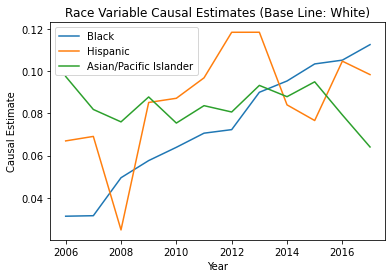

In [ ]:
import seaborn as sns
years = list(range(2006, 2018))
sns.lineplot(x = years, y = black, palette = 'red', label="Black")
sns.lineplot(x = years, y = hispanic, palette = 'blue', label="Hispanic")
sns.lineplot(x = years, y = asianpacific, palette = 'green', label="Asian/Pacific Islander")
plt.title('Race Variable Causal Estimates (Base Line: White)')
plt.xlabel('Year')
plt.ylabel('Causal Estimate')
plt.legend()
plt.savefig('Causal_Estimate_Trend(All_Violations)')
plt.show()

In [ ]:
list(range(2006,2018))

In [ ]:
coef_dict = {'black': black, 'hispanic': hispanic, 'asianpacific': asianpacific}
coef_df = pd.DataFrame.from_dict(coef_dict, orient='index')
coef_df.columns = list(range(2006,2018))
#dt = df.transpose()
coef_df.to_csv('causal_estimates.csv', index=True, header=True, encoding='utf-8')
coef_df.head()

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
black,0.031219,0.031459,0.049483,0.057625,0.063923,0.070634,0.072315,0.090043,0.095405,0.103502,0.105298,0.112659
hispanic,0.066965,0.069094,0.024714,0.085204,0.087197,0.096892,0.118525,0.118541,0.084067,0.076638,0.104812,0.098431
asianpacific,0.097559,0.081889,0.075994,0.087826,0.075431,0.083691,0.080685,0.093306,0.087954,0.095008,0.079297,0.064083
